# Fullcase Case Study
Humza Azhar Butt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
from sklearn.linear_model import LinearRegression

from scipy import stats

# Initialize seaborn (for plotting)
sns.set()

## Load Data

In [31]:
# Center
dfCenters = pd.read_csv("centers.csv", index_col=0)
# Regional Demand over Time
dfdemand = pd.read_csv("demands.csv")
# Center To Region Distances
dfDistances = pd.read_csv("distances.csv")

## Forecasting Demand

In [32]:
#Create Dummy Variable for Linear Regression
df=pd.get_dummies(dfdemand, prefix=['reg'])

In [33]:
#Create Linear Regression
x=df.drop(columns="Demand")
y=df["Demand"]
reg = LinearRegression().fit(x,y)
reg.score(x, y)

0.9868809805753387

In [34]:
#Predict Demand for 2021-2025 for each Region
for j in range(2021,2026):
    a=reg.predict(np.array([[j, 1, 0, 0, 0, 0, 0, 0]]))
    row={"Year":j, "Region":"Downtown Toronto", "Demand":a[0]}
    dfdemand = dfdemand.append(row, ignore_index=True)
    b=reg.predict(np.array([[j, 0, 1, 0, 0, 0, 0, 0]]))
    row={"Year":j, "Region":"East York", "Demand":b[0]}
    dfdemand = dfdemand.append(row, ignore_index=True)
    c=reg.predict(np.array([[j, 0, 0, 1, 0, 0, 0, 0]]))
    row={"Year":j, "Region":"Etobicoke", "Demand":c[0]}
    dfdemand = dfdemand.append(row, ignore_index=True)
    d=reg.predict(np.array([[j, 0, 0, 0, 1, 0, 0, 0]]))
    row={"Year":j, "Region":"Mississauga East", "Demand":d[0]}
    dfdemand = dfdemand.append(row, ignore_index=True)
    e=reg.predict(np.array([[j, 0, 0, 0, 0, 1, 0, 0]]))
    row={"Year":j, "Region":"North Toronto", "Demand":e[0]}
    dfdemand = dfdemand.append(row, ignore_index=True)
    f=reg.predict(np.array([[j, 0, 0, 0, 0, 0, 1, 0]]))
    row={"Year":j, "Region":"North York", "Demand":f[0]}
    dfdemand = dfdemand.append(row, ignore_index=True)
    g=reg.predict(np.array([[j, 0, 0, 0, 0, 0, 0, 1]]))
    row={"Year":j, "Region":"Scarborough East", "Demand":g[0]}
    dfdemand = dfdemand.append(row, ignore_index=True)

#Convert Float Demand to Integer
dfdemand["Demand"]=dfdemand["Demand"].astype('int64')

<AxesSubplot:xlabel='Year', ylabel='Demand'>

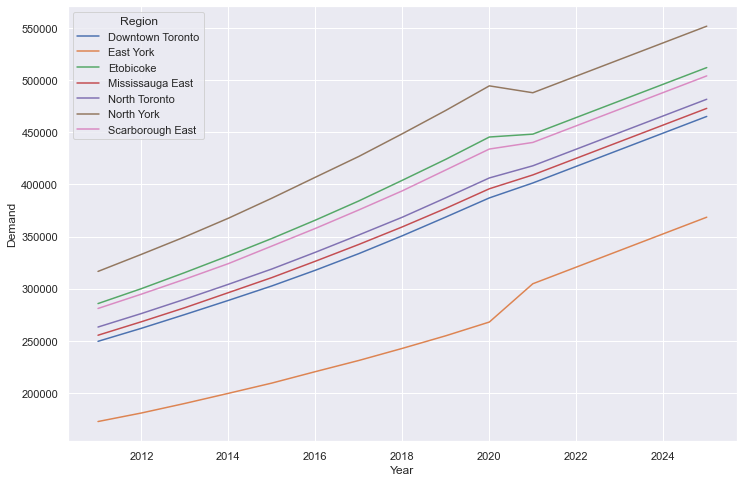

In [35]:
#Generate Graph of Forecasted Demand
plt.figure(figsize=(12,8))
sns.lineplot(x="Year",y="Demand",data=dfdemand,hue="Region")

## Sets

In [36]:
# Centers
centers = list(dfCenters.index)
numcenters= len(centers)

# Region or Zones
zones = list(dfdemand["Region"].unique())
numzones = len(zones)

# Years
year = dfdemand["Year"].unique()
numyear = len(year)

#Distance from Centers to Regions
distance = dfDistances["Distance"].unique()
numdistance = len(distance)


## Parameters

In [37]:
# Demand in each Region per Time
regiondemand = {}
for j in zones:
    for s in year:
        regiondemand[(j,s)] = float(dfdemand[(dfdemand["Region"] == j) & (dfdemand["Year"] == s)]["Demand"])

In [38]:
# Center Capacities
centercapacity = {}
for i in centers:
    centercapacity[i] = int(dfCenters.loc[i]["Num MPs"]*24*250)

In [39]:
# Center Employees
centermps = {}
for i in centers:
    centermps[i] = int(dfCenters.loc[i]["Num MPs"])

In [40]:
# Center Max Capacities
centermax = {}
for i in centers:
    centermax[i] = int(dfCenters.loc[i]["Maximum capacity"])

In [41]:
centermax

{'Center A': 5000000,
 'Center B': 5000000,
 'Center C': 5000000,
 'Center D': 5000000,
 'Center E': 5000000,
 'Center F': 5000000}

In [42]:
# Distance Cost per Centers
centerregioncost = {}
for i in centers:
    for j in zones:
         for s in year[10:]:
            centerregioncost[(i,j,s)] = float(dfDistances[(dfDistances["Center"] == i)&(dfDistances["Region"]==j)]["Distance"]*0.25)

In [43]:
#Operating Cost of Center
centercost={}
for i in centers:
        for s in year[10:]:
            centercost[i,s] = int(dfCenters.loc[i]["Operating Costs"])

In [44]:
#Open Cost for Center
centeropencost={}
for i in centers:
    for s in year[10:]:
        centeropencost[(i,s)] = int(dfCenters.loc[i]["Opening Costs"])
        centeropencost[("Center A",2021)]=int(dfCenters.loc["Center A"]["Opening Costs"])
        centeropencost[("Center B",2021)]=int(dfCenters.loc["Center B"]["Opening Costs"])
        centeropencost[("Center C",2021)]=int(dfCenters.loc["Center C"]["Opening Costs"])
        centeropencost[("Center D",2021)]=int(dfCenters.loc["Center D"]["Opening Costs"])
        centeropencost[("Center E",2021)]=int(dfCenters.loc["Center E"]["Opening Costs"])
        centeropencost[("Center E",2022)]=0
        centeropencost[("Center E",2023)]=0
        centeropencost[("Center E",2024)]=0
        centeropencost[("Center E",2025)]=0
        centeropencost[("Center F",2021)]=int(dfCenters.loc["Center F"]["Opening Costs"])
        centeropencost[("Center F",2022)]=0
        centeropencost[("Center F",2023)]=0
        centeropencost[("Center F",2024)]=0
        centeropencost[("Center F",2025)]=0
    

In [45]:
#Labor Costs
wages={}
overtime={}
reimbursement={}
for s in year[10:]:
    wages[s] = 35*1.025**(s-2021)
    overtime[s]= wages[s]*1.5
    reimbursement[s]=-40

# Model

In [46]:
# Initialize model and objective sense
model = pulp.LpProblem(name="Model", sense=pulp.LpMinimize)

## Variables

In [47]:
#Employees allocated to each zone per year
pvar = pulp.LpVariable.dict("employees_allocated", (centers, zones, year), lowBound=0.0, cat=pulp.LpInteger)

#Number of employees per center per year
wvar = pulp.LpVariable.dict("work_flow", (centers,year), lowBound=0.0, cat=pulp.LpInteger)

# New hires 
nvar = pulp.LpVariable.dict("new_hires", (centers, year), lowBound=0.0, upBound=100.0, cat=pulp.LpInteger)

# Open Center Indicator Variable
yvar = pulp.LpVariable.dict("opening", (centers,year), cat=pulp.LpBinary)

#Overtime Hours Allocated to each zone per year 
ovar = pulp.LpVariable.dict("overtime_hours_allocated", (centers, zones, year), lowBound=0.0, cat=pulp.LpContinuous)


## Constraints

In [48]:
# Contraint: demand must be satisfied in all scenarios
for j in zones:
    for s in year[10:]: 
        #6*250 is the maximum number of hours an employee can work in regular hours
        hours_alloc=pulp.lpSum( 6*250*[pvar[(i,j,s)] for i in centers]) + pulp.lpSum( [ovar[(i,j,s)] for i in centers]) 
        #greater than to take into account decrease in demand from last year
        model += hours_alloc >= regiondemand[j,s] 

In [49]:
# Contraint: Center A-E are already open
for i in centers[0:4]:
    for s in year[10:]:       
        model += (yvar[i,s] ==1)
        #model+=yvar["Center E", s]==0
       # model+=yvar["Center F", s]==0

In [50]:
# Contraint: Hours allocated must be below the maximum capacity of each center
for i in centers:   
    for s in year[10:]:    
        #Indicator variable used when centers are not opened
        model += hours_alloc<= centermax[i] * yvar[i,s]

In [51]:
#max number of hires allowed
hires=100
for i in centers:   
    for s in year[10:]:       
        #Constraint:Hiring cannot be negative and must be less than or equal to 100
        model += (nvar[i,s] <= hires*yvar[i,s])
        model += (nvar[i,s] >= 0)
        #Constraint: Number of workers equals the number of workers from last year plus the number of hires this year
        num_workers=(wvar[i,s-1] if s > 2021 else centermps[i]) + nvar[i,s]
        #Constraint: Workers this year must be equal to the number of workers
        model +=(wvar[i,s] == num_workers)   

        #Constraint:If store is opened it cannot close
        model +=yvar[i,s-1]<=yvar[i,s]
      
        #Constraint Sum of hours allocated during regular hours from a center to regions must be equal to the full capacity of the workers available in a center
        model+=pulp.lpSum( 6*250*[pvar[(i,j,s)] for j in zones]) ==6*250*wvar[i,s]
        #Constraint:Total hours allocated cannot be greater than 24 hours in a working day
        model += pulp.lpSum((6*250*[pvar[(i,j,s)] for j in zones])+ [ovar[(i,j,s)] for j in zones]) <=24*250*wvar[i,s]

## Objective Function

In [52]:
# Objective function

# --- Total Costs

obj = pulp.lpSum( ([ centercost[i,s] * yvar[i,s] for i in centers for s in year[10:]] + [ 15000 * nvar[(i,s)] for i in centers for s in year[10:]] + [ (wages[s]+centerregioncost[(i,j,s)]+reimbursement[s])*6*250*pvar[(i,j,s)] for i in centers for j in zones for s in year[10:] ] +[ (overtime[s]+centerregioncost[(i,j,s)] 
+reimbursement[s])*ovar[(i,j,s)] for i in centers for j in zones for s in year[10:]] + [centeropencost[i,s]* yvar[i,s] for i in centers for s in year[10:]]))

# add objective to model
model += obj


## Solution Process

In [53]:
# Write LP to file (optional, but often good to inspect model and find errors)
model.writeLP("Model6.lp")

# Solve model
model.solve()
print("Status:", pulp.LpStatus[model.status])

Status: Optimal


In [54]:
# Total cost
totalCost = pulp.value(model.objective)
print("Total cost: " + str(totalCost))

Total cost: 36415608.78788758


In [55]:
# Print solution (you can add to the dataframe if needed)
for i in centers:
    if yvar[i,s].varValue > 0:
        print(str(i) + " is opened")
        
        for s in year[10:]:
            print("\n")
            print("\tYear " + str(s) + ":")
            for j in zones:
                if pvar[(i,j,s)].varValue > 0.0 or ovar[(i,j,s)].varValue > 0.0:
                    print("\t\tServes Region " + str(j) + " - with hours allocated " + str(pvar[(i,j,s)].varValue)+" - capacity filled "+str((pvar[(i,j,s)].varValue)*6*250/(regiondemand[j,s]) ))
                    print("\t\tServes Region " + str(j) + " - with overtime hours allocated " + str(ovar[(i,j,s)].varValue)+" - capacity filled "+str((ovar[(i,j,s)].varValue)/(regiondemand[j,s]) ))
                    print("\n")

                    print("Demand in region :"+str(regiondemand[j,s]))
            print("num_employees hired :"+str(nvar[i,s].varValue))
            print("num_employees :"+str(wvar[i,s].varValue))
            print("Total Capacity Available Regular Time:"+str((wvar[i,s].varValue*6*250)))
            print("Total Capacity Available Overtime:"+str((wvar[i,s].varValue*18*250)))
            print("Total Capacity Overall:"+str((wvar[i,s].varValue*24*250)))
           # print("Overtime Hours :"+str(ovar[i,j,s].varValue))


        print("\n")


Center A is opened


	Year 2021:
		Serves Region East York - with hours allocated 0.0 - capacity filled 0.0
		Serves Region East York - with overtime hours allocated 304761.0 - capacity filled 1.0


Demand in region :304761.0
		Serves Region North Toronto - with hours allocated 0.0 - capacity filled 0.0
		Serves Region North Toronto - with overtime hours allocated 104.0 - capacity filled 0.0002489324627080022


Demand in region :417784.0
		Serves Region North York - with hours allocated 315.0 - capacity filled 0.9686446150534548
		Serves Region North York - with overtime hours allocated 15295.0 - capacity filled 0.03135538494654517


Demand in region :487795.0
num_employees hired :100.0
num_employees :315.0
Total Capacity Available Regular Time:472500.0
Total Capacity Available Overtime:1417500.0
Total Capacity Overall:1890000.0


	Year 2022:
		Serves Region East York - with hours allocated 80.0 - capacity filled 0.37417681101576533
		Serves Region East York - with overtime hours alloc

In [56]:
total=[]
for i in centers:
            total.append(wvar[i,2025].varValue)

In [57]:
total

[592.0, 336.0, 309.0, 330.0, 371.0, 300.0]